| File            | Mục đích                                                    | Cột chính                                  |
| --------------- | ----------------------------------------------------------- | ------------------------------------------ |
| **movies.csv**  | Thông tin phim (metadata)                                   | `movieId`, `title`, `genres`               |
| **ratings.csv** | Dữ liệu đánh giá (interaction chính)                        | `userId`, `movieId`, `rating`, `timestamp` |
| **tags.csv**    | Ghi chú / từ khóa do người dùng gắn cho phim (metadata phụ) | `userId`, `movieId`, `tag`, `timestamp`    |


⚙️ Bước 1: Đọc dữ liệu

In [1]:
import pandas as pd

movies = pd.read_csv(r'dataset\movies.csv')
ratings = pd.read_csv(r'dataset\ratings.csv')
tags = pd.read_csv(r'dataset\tags.csv')

print(movies.head())
print(ratings.head())
print(tags.head())
print(len(movies), len(ratings), len(tags))


   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
   userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996
2       2    60756     will ferre

Làm sạch dữ liệu cơ bản

In [2]:
print(movies.isnull().sum())
print(ratings.isnull().sum())
print(tags.isnull().sum())
movies = movies.dropna()
ratings = ratings.dropna()
tags = tags.dropna(subset=['tag'])

movieId    0
title      0
genres     0
dtype: int64
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64


In [3]:
ratings = ratings.drop_duplicates()
tags = tags.drop_duplicates()
print(len(movies), len(ratings), len(tags))


9742 100836 3683


Gộp dữ liệu

In [4]:
data = pd.merge(ratings, movies, on='movieId', how='left')
print(data.head())

   userId  movieId  rating  timestamp                        title  \
0       1        1     4.0  964982703             Toy Story (1995)   
1       1        3     4.0  964981247      Grumpier Old Men (1995)   
2       1        6     4.0  964982224                  Heat (1995)   
3       1       47     5.0  964983815  Seven (a.k.a. Se7en) (1995)   
4       1       50     5.0  964982931   Usual Suspects, The (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                               Comedy|Romance  
2                        Action|Crime|Thriller  
3                             Mystery|Thriller  
4                       Crime|Mystery|Thriller  


In [5]:
# Làm sạch cột 'genres'
movies['genres'] = movies['genres'].str.replace('|', ',', regex=False)

print("----- Dữ liệu cột 'genres' sau khi xử lý -----")

# Gộp dữ liệu
data = pd.merge(ratings, movies, on='movieId', how='left')

# Bỏ cột 'timestamp'
data = data.drop(columns=['timestamp'])

# Lưu file
data.to_csv('merged_movie_data.csv', index=False, encoding='utf-8')
print("đã lưu 👍:")
print(data.head())


----- Dữ liệu cột 'genres' sau khi xử lý -----
đã lưu 👍:
   userId  movieId  rating                        title  \
0       1        1     4.0             Toy Story (1995)   
1       1        3     4.0      Grumpier Old Men (1995)   
2       1        6     4.0                  Heat (1995)   
3       1       47     5.0  Seven (a.k.a. Se7en) (1995)   
4       1       50     5.0   Usual Suspects, The (1995)   

                                        genres  
0  Adventure,Animation,Children,Comedy,Fantasy  
1                               Comedy,Romance  
2                        Action,Crime,Thriller  
3                             Mystery,Thriller  
4                       Crime,Mystery,Thriller  


In [6]:
data = pd.read_csv('merged_movie_data.csv')
print(data.head())

   userId  movieId  rating                        title  \
0       1        1     4.0             Toy Story (1995)   
1       1        3     4.0      Grumpier Old Men (1995)   
2       1        6     4.0                  Heat (1995)   
3       1       47     5.0  Seven (a.k.a. Se7en) (1995)   
4       1       50     5.0   Usual Suspects, The (1995)   

                                        genres  
0  Adventure,Animation,Children,Comedy,Fantasy  
1                               Comedy,Romance  
2                        Action,Crime,Thriller  
3                             Mystery,Thriller  
4                       Crime,Mystery,Thriller  


import thư viện cần thiết

```python

In [19]:
# Cell 1
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split

# Đọc dữ liệu
data = pd.read_csv('merged_movie_data.csv')
# data = data.sample(10000, random_state=42)
print("📄 Dữ liệu mẫu:")
print(data.head())


📄 Dữ liệu mẫu:
   userId  movieId  rating                        title  \
0       1        1     4.0             Toy Story (1995)   
1       1        3     4.0      Grumpier Old Men (1995)   
2       1        6     4.0                  Heat (1995)   
3       1       47     5.0  Seven (a.k.a. Se7en) (1995)   
4       1       50     5.0   Usual Suspects, The (1995)   

                                        genres  
0  Adventure,Animation,Children,Comedy,Fantasy  
1                               Comedy,Romance  
2                        Action,Crime,Thriller  
3                             Mystery,Thriller  
4                       Crime,Mystery,Thriller  


In [8]:
# Loại bỏ phim trùng lặp trước khi xử lý genres
data = data.drop_duplicates(subset=['movieId', 'title']).reset_index(drop=True)

# Kiểm tra số lượng sau khi loại trùng
print("✅ Số phim duy nhất còn lại:", len(data))
print(data[['movieId', 'title']].head())

✅ Số phim duy nhất còn lại: 9724
   movieId                        title
0        1             Toy Story (1995)
1        3      Grumpier Old Men (1995)
2        6                  Heat (1995)
3       47  Seven (a.k.a. Se7en) (1995)
4       50   Usual Suspects, The (1995)


In [9]:
# Điền giá trị trống trong 'genres'
data['genres'] = data['genres'].fillna('')

# Chuẩn hóa chuỗi: bỏ khoảng trắng thừa
data['genres'] = data['genres'].str.replace(' ', '')

# Kiểm tra lại dữ liệu sau xử lý
print("✅ Sau xử lý cột genres:")
print(data[['title', 'genres']].head())


✅ Sau xử lý cột genres:
                         title                                       genres
0             Toy Story (1995)  Adventure,Animation,Children,Comedy,Fantasy
1      Grumpier Old Men (1995)                               Comedy,Romance
2                  Heat (1995)                        Action,Crime,Thriller
3  Seven (a.k.a. Se7en) (1995)                             Mystery,Thriller
4   Usual Suspects, The (1995)                       Crime,Mystery,Thriller


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Reset lại index để đồng bộ thứ tự
data = data.reset_index(drop=True)

# TF-IDF vectorizer
tfidf = TfidfVectorizer(token_pattern=r"[^,]+")
tfidf_matrix = tfidf.fit_transform(data['genres'])

# Tính cosine similarity
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Tạo mapping chính xác: title → vị trí (0..len(data)-1)
indices = pd.Series(data.index, index=data['title']).drop_duplicates()

print("✅ TF-IDF và cosine similarity đã tạo đồng bộ!")


✅ TF-IDF và cosine similarity đã tạo đồng bộ!


Hàm lưu model

In [11]:
import pickle

def save_model(model, path='svd_model.pkl'):
    """Lưu mô hình Surprise SVD vào file"""
    with open(path, 'wb') as f:
        pickle.dump(model, f)
    print(f"✅ Mô hình đã được lưu vào '{path}'")

def load_model(path='svd_model.pkl'):
    """Load mô hình Surprise SVD từ file"""
    with open(path, 'rb') as f:
        model = pickle.load(f)
    print(f"✅ Mô hình đã được load từ '{path}'")
    return model


In [12]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split, cross_validate

# Cấu hình Reader cho dữ liệu rating (thang điểm 0.5–5.0)
reader = Reader(rating_scale=(0.5, 5.0))

# Chỉ lấy các cột cần thiết
data_surprise = Dataset.load_from_df(data[['userId', 'movieId', 'rating']], reader)

# Chia train/test
trainset, testset = train_test_split(data_surprise, test_size=0.2, random_state=42)

# Huấn luyện mô hình SVD
model = SVD(n_factors=50, random_state=42)
model.fit(trainset)

# Lưu mô hình
save_model(model, path='svd_model.pkl')

# Dự đoán ví dụ
predictions = model.test(testset)


✅ Mô hình đã được lưu vào 'svd_model.pkl'


Đánh giá mô hình bằng RMSE, MAE

In [13]:
from surprise import accuracy

rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

print(f"✅ RMSE: {rmse:.4f}")
print(f"✅ MAE : {mae:.4f}")


RMSE: 0.9412
MAE:  0.7390
✅ RMSE: 0.9412
✅ MAE : 0.7390


Đánh giá bằng Precision, Recall, F1

In [14]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    '''Trả về top-n phim được đề xuất cho từng user'''
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Tính Precision@K và Recall@K'''
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions, recalls = {}, {}
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return sum(precisions.values()) / len(precisions), sum(recalls.values()) / len(recalls)

# k quyết định số lượng gợi ý hàng đầu, threshold là giá trị rating mà bạn coi là user thích
precision, recall = precision_recall_at_k(predictions, k=20, threshold=3) 
print(f"✅ Precision@10: {precision:.4f}")
print(f"✅ Recall@10   : {recall:.4f}")


✅ Precision@10: 0.7233
✅ Recall@10   : 0.7619


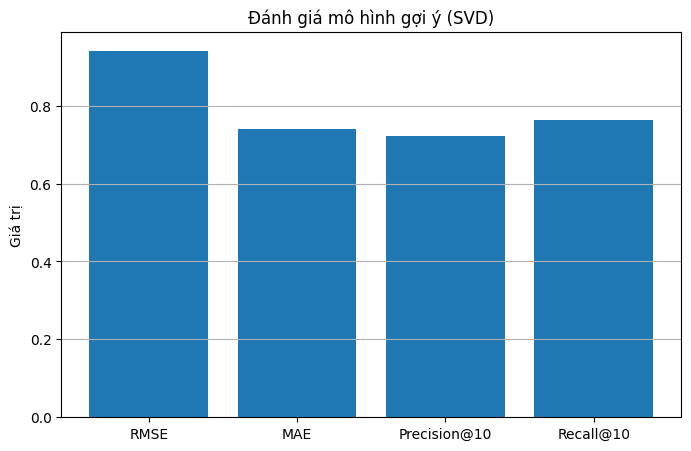

In [15]:
import matplotlib.pyplot as plt

metrics = ['RMSE', 'MAE', 'Precision@10', 'Recall@10']
values = [rmse, mae, precision, recall]

plt.figure(figsize=(8,5))
plt.bar(metrics, values)
plt.title("Đánh giá mô hình gợi ý (SVD)")
plt.ylabel("Giá trị")
plt.grid(axis='y')
plt.show()


In [16]:
def hybrid_recommend(user_id, title, top_n=5):
    if title not in indices:
        return f"❌ Phim '{title}' không tồn tại trong dataset."
    
    idx = indices[title]
    if isinstance(idx, pd.Series):  # nếu có nhiều bản trùng
        idx = idx.iloc[0]           # chọn bản đầu tiên

    # --- Content-based ---
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:50]
    
    movie_indices = [i[0] for i in sim_scores]
    similar_movies = data.iloc[movie_indices][['movieId', 'title', 'genres']].copy()

    # --- Collaborative Filtering ---
    similar_movies['est_rating'] = similar_movies['movieId'].apply(
        lambda x: model.predict(user_id, x).est
    )

    # --- Trả kết quả ---
    recommendations = similar_movies.sort_values('est_rating', ascending=False).head(top_n)
    return recommendations[['title', 'genres', 'est_rating']]


In [17]:
movie_input = "Presto (2008)"
print(indices[movie_input])
print(cosine_sim.shape)


4348
(9724, 9724)


Test với id là 2

In [18]:
user_id = 2
movie_input = "Presto (2008)"

print(f"🎬 Gợi ý cho user {user_id} dựa trên phim '{movie_input}':\n")
recommendations = hybrid_recommend(user_id, movie_input, top_n=10)
print(recommendations)


🎬 Gợi ý cho user 2 dựa trên phim 'Presto (2008)':

                                              title  \
7709  Puss in Boots (Nagagutsu o haita neko) (1969)   
1592                                    Antz (1998)   
122                      Black Cauldron, The (1985)   
817                                     Cars (2006)   
4448                    Wow! A Talking Fish! (1983)   
4836                       Last Unicorn, The (1982)   
1905                         Shrek the Third (2007)   
4348                                  Presto (2008)   
4624                                   Moana (2016)   
4439            Last Year's Snow Was Falling (1983)   

                                                 genres  est_rating  
7709  Adventure,Animation,Children,Comedy,Fantasy,Ro...    4.127959  
1592        Adventure,Animation,Children,Comedy,Fantasy    4.123208  
122                Adventure,Animation,Children,Fantasy    4.121290  
817                           Animation,Children,Comedy    4.11